In [1]:
#讀入資料庫，使用UJIIndoorLoc dataset
train <- read.csv("trainingData.csv")
valid <- read.csv("validationData.csv")

library(dplyr)
library(ISLR)
library(lattice)
library(ggplot2)
library(caret)
library(caTools)
library(gridExtra)
library(ranger)
library(e1071)

#Separate data by building in train & valid 過濾出BUILDINGID == 2的資料
training.set <- filter(train, BUILDINGID == 2 & FLOOR == 3)
validation.set <- filter(valid, BUILDINGID == 2 & FLOOR == 3)

#The similarity between the validation features and the training set will be calculated as the euclidean distance between them:
n_observations <- nrow(training.set)
n_features     <- ncol(training.set) - 9 #AP1  -AP520 #520

distances      <- matrix(0, nrow(validation.set), n_observations)
#採用 Euclidean distance 作為 distance 計算之演算法
for (j in 1:nrow(validation.set)) #跑一個一個測資測試準確度
{
    for (i in 1:n_observations) 
    { 
      #training的數值預估測資的location
      distances[j, i] <- sqrt(sum((abs(training.set[i, 1:n_features]) - abs(validation.set[j, 1:n_features]))^2))
    }
}


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




[1] "k=1 average"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    4.60    9.18   11.41   18.54   32.49 

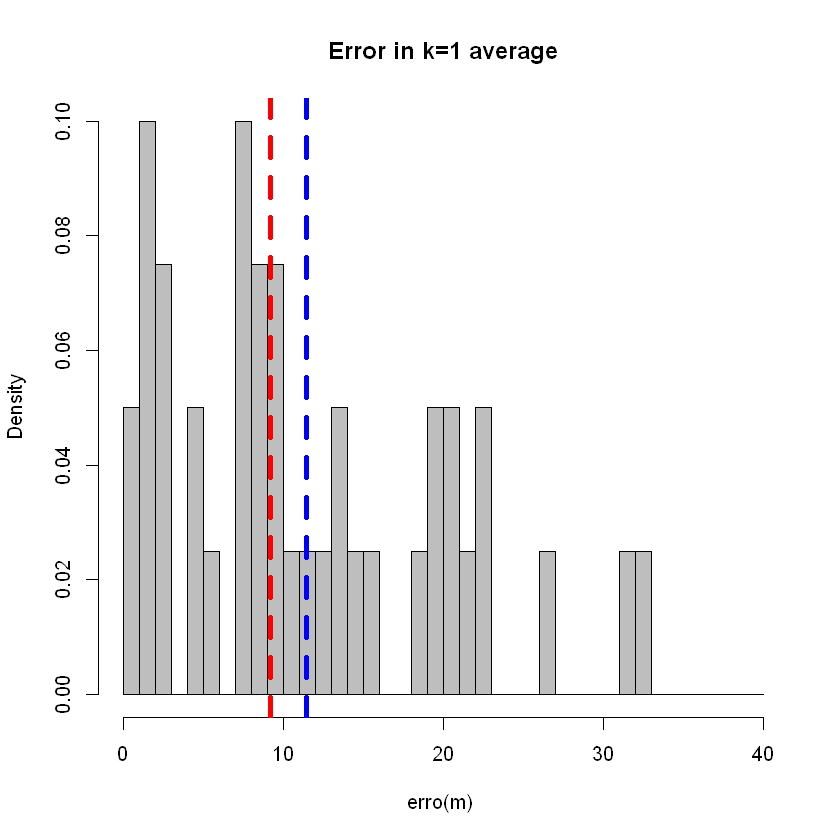

In [72]:
#讀入 ValiationData.csv，一筆資料做一次測試，計算真實座標與預估座標的誤差。
#1NN
average1Erro <- numeric(nrow(validation.set))
for (j in 1:nrow(validation.set)) #跑一個一個測資測試準確度
{   
    #k=1
    neares <- order(distances[j, 1:n_observations])[1] #算跟各個測資(j in 1:nrow(validation.set))距離最近的三個training的數值
    neares
    # average
    tx <- training.set[neares, 521]
    ty <- training.set[neares, 522]
    a <- (tx - validation.set[j, 521])^2
    b <- (ty - validation.set[j, 522])^2
    average1Erro[j] <- sqrt(a+b)
}

print("k=1 average")
hist(average1Erro[1:40], freq = FALSE, breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40), xlab = "erro(m) ", col = "gray", main = "Error in k=1 average")
abline(v=mean(average1Erro[1:40]),col="blue", lty=2, lwd=4)
abline(v=median(average1Erro[1:40]),col="red", lty=2, lwd=4)
summary(average1Erro[1:40])

In [51]:
#3NN
average3Erro <- numeric(nrow(validation.set))
weights3Erro <- numeric(nrow(validation.set))
for (j in 1:nrow(validation.set)) #跑一個一個測資測試準確度
{   
    #k=3
    neares <- order(distances[j, 1:n_observations])[1:3] #算跟各個測資(j in 1:nrow(validation.set))距離最近的三個training的數值
    neares
    # average
    tx <- sum(training.set[neares, 521])/3
    ty <- sum(training.set[neares, 522])/3
    a <- (tx - validation.set[j, 521])^2
    b <- (ty - validation.set[j, 522])^2
    average3Erro[j] <- sqrt(a+b)
    #W
    weights <- 1 / distances[j, neares]
    weights <- weights / sum(weights) # Normalize the weights so their sum is 1
    ex <- sum(training.set[neares, 521]*weights)
    ey <- sum(training.set[neares, 522]*weights)
    ea <- (ex - validation.set[j, 521])^2
    eb <- (ey - validation.set[j, 522])^2
    weights3Erro[j] <- sqrt(ea+eb)
}

[1] "k=3 average"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.227   8.090  10.424  14.905  35.092 

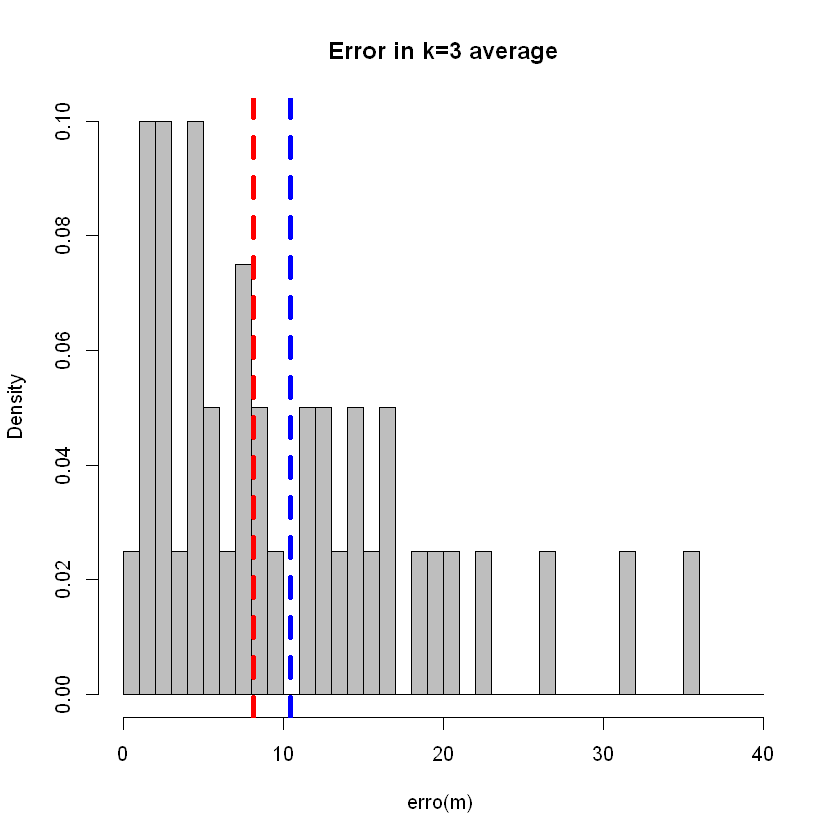

In [73]:
print("k=3 average")
hist(average3Erro[1:40], freq = FALSE, breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40), xlab = "erro(m) ", col = "gray", main = "Error in k=3 average")
abline(v=mean(average3Erro[1:40]),col="blue", lty=2, lwd=4)
abline(v=median(average3Erro[1:40]),col="red", lty=2, lwd=4)
summary(average3Erro[1:40])

[1] "k=3 weight"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   4.222   8.090  10.442  14.905  35.038 

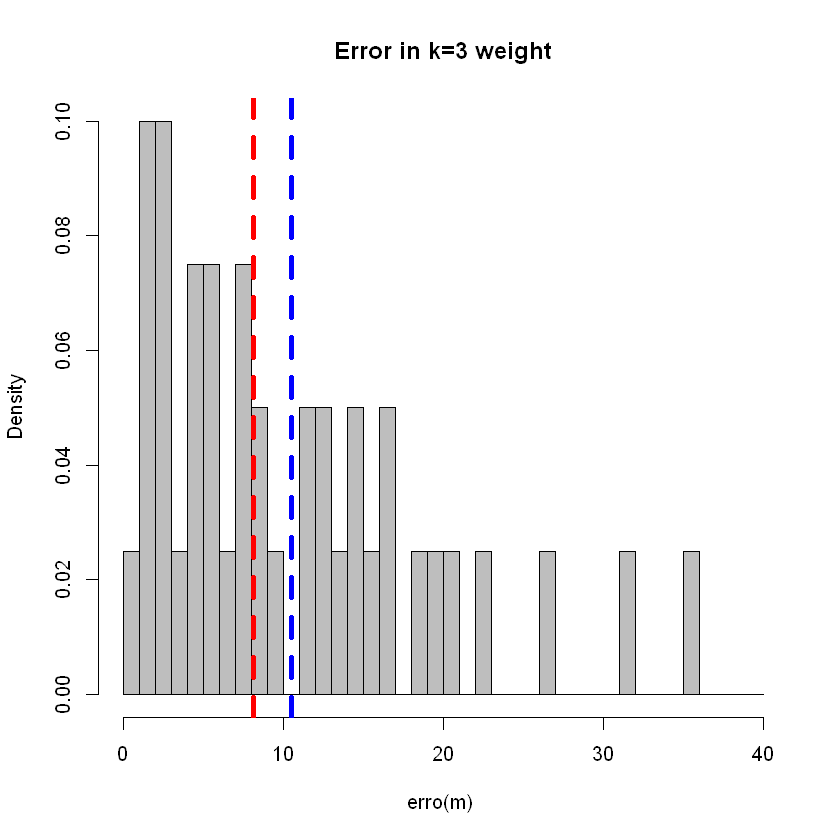

In [74]:
print("k=3 weight")
hist(weights3Erro[1:40], freq = FALSE, breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40), xlab = "erro(m) ", col = "gray", main = "Error in k=3 weight")
abline(v=mean(weights3Erro[1:40]),col="blue", lty=2, lwd=4)
abline(v=median(weights3Erro[1:40]),col="red", lty=2, lwd=4)
summary(weights3Erro[1:40])

In [77]:
#5NN
average5Erro <- numeric(nrow(validation.set))
weights5Erro <- numeric(nrow(validation.set))
for (j in 1:nrow(validation.set)) #跑一個一個測資測試準確度
{   
    #k=5
    neares <- order(distances[j, 1:n_observations])[1:5] #算跟各個測資(j in 1:nrow(validation.set))距離最近的三個training的數值
    neares
    # average
    tx <- sum(training.set[neares, 521])/5
    ty <- sum(training.set[neares, 522])/5
    a <- (tx - validation.set[j, 521])^2
    b <- (ty - validation.set[j, 522])^2
    average5Erro[j] <- sqrt(a+b)
    #W
    weights <- 1 / distances[j, neares]
    weights <- weights / sum(weights) # Normalize the weights so their sum is 1
    ex <- sum(training.set[neares, 521]*weights)
    ey <- sum(training.set[neares, 522]*weights)
    ea <- (ex - validation.set[j, 521])^2
    eb <- (ey - validation.set[j, 522])^2
    weights5Erro[j] <- sqrt(ea+eb)
}

[1] "k=5 average"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.450   6.996  10.086  14.984  35.614 

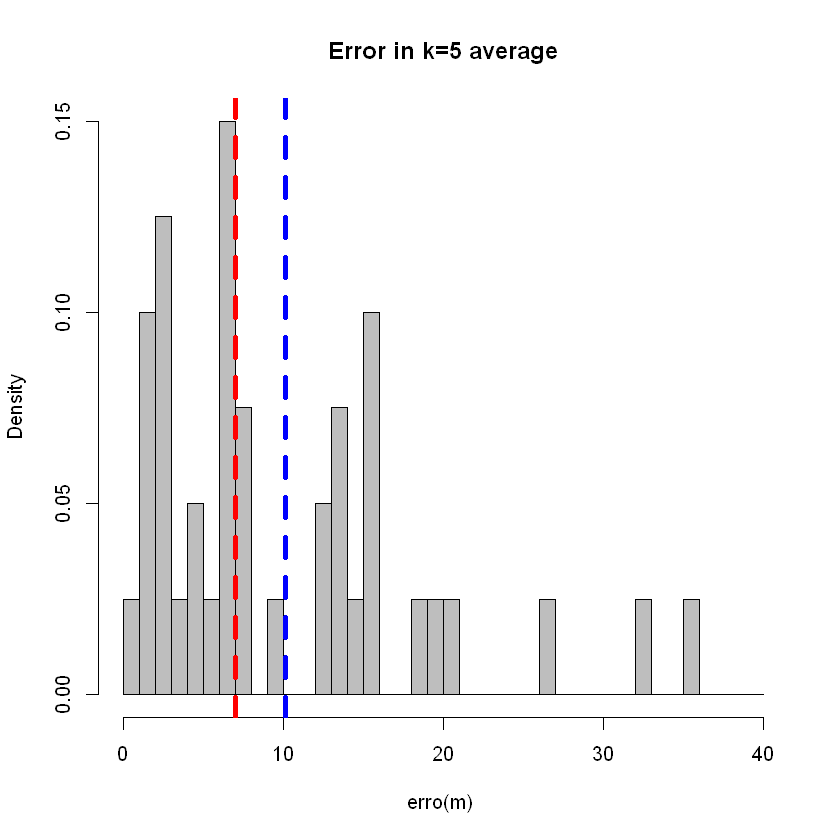

In [75]:
print("k=5 average")
hist(average5Erro[1:40], freq = FALSE, breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40), xlab = "erro(m) ", col = "gray", main = "Error in k=5 average")
abline(v=mean(average5Erro[1:40]),col="blue", lty=2, lwd=4)
abline(v=median(average5Erro[1:40]),col="red", lty=2, lwd=4)
summary(average5Erro[1:40])

[1] "k=5 weight"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.474   7.170  10.101  15.023  35.566 

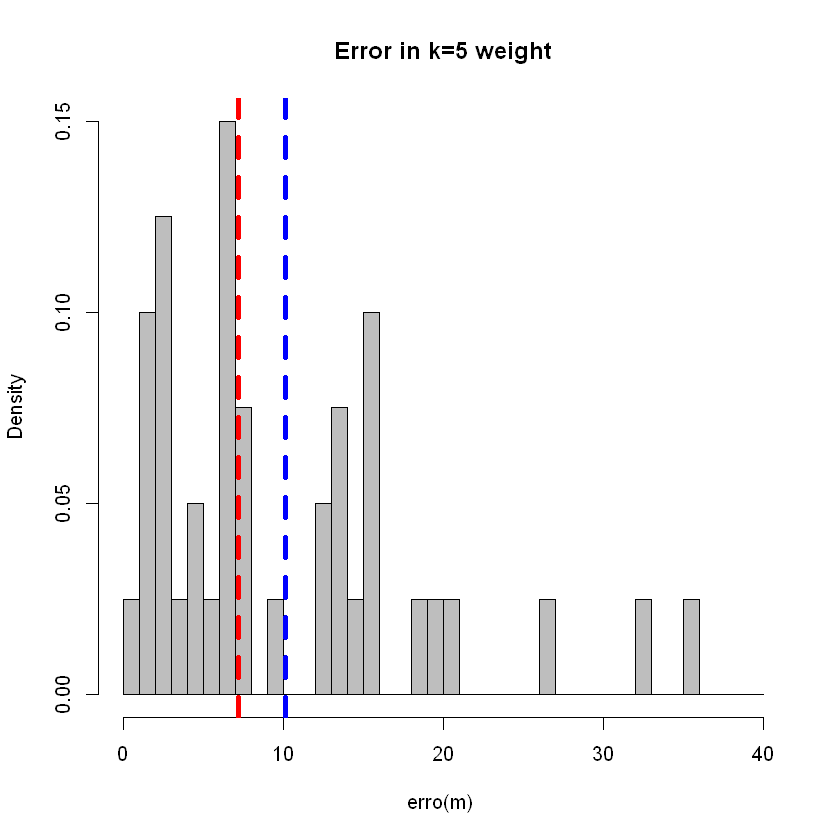

In [76]:
print("k=5 weight")
hist(weights5Erro[1:40], freq = FALSE, breaks = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40), xlab = "erro(m) ", col = "gray", main = "Error in k=5 weight")
abline(v=mean(weights5Erro[1:40]),col="blue", lty=2, lwd=4)
abline(v=median(weights5Erro[1:40]),col="red", lty=2, lwd=4)
summary(weights5Erro[1:40])